In [1]:
!pip3 install tensorflow==2.14.0
!pip3 install scikeras==0.12.0
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install cartopy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from scikeras.wrappers import KerasRegressor

2024-05-01 00:31:34.745719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 00:31:34.745761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 00:31:34.745788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 00:31:34.754377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.random.set_seed(42)

In [4]:
gpu = tf.config.list_physical_devices('GPU')
if not gpu:
    print("No GPU was detected")
else:
    print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Reading train and test datasets

In [5]:
df_train = pd.read_csv("/tf/notebooks/data/train.csv")
df_test = pd.read_csv("/tf/notebooks/data/test.csv")

In [6]:
def remove_outliers(df, quantile=0.05):
    Q1 = df.quantile(quantile)
    Q3 = df.quantile(1-quantile)
    IQR = Q3 - Q1
    
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

def apply_feature_engineering(df: pd.DataFrame, keep_outliers) -> pd.DataFrame:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())
    custom_encoding = {"ISLAND": 4, "NEAR OCEAN": 3, "NEAR BAY": 2, "<1H OCEAN": 1, "INLAND": 0}
    df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
    df = df.drop("ocean_proximity", axis=1)
    df["rooms_per_bedroom"] = df["total_rooms"] / df["total_bedrooms"]
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["encoded_position"] = df["longitude"] + df["latitude"]
    df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]
    df["target"] = df["median_house_value"]
    df = df.drop("median_house_value", axis=1)
    if not keep_outliers:
        df = remove_outliers(df, 0.05)
    return df

In [7]:
df_train = apply_feature_engineering(df_train, True)
df_test = apply_feature_engineering(df_test, False)

X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"]

/tmp/ipykernel_8541/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
/tmp/ipykernel_8541/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]


# Baseline

In [8]:
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))
pipe.steps.append(("reg", LinearRegression()))
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_predict)

69086.5477912973

In [9]:
def plot_rmse(history):
    loss = np.sqrt(history["loss"])
    val_loss = np.sqrt(history["val_loss"])
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")

def rmse(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_pred - y_true))**0.5

# Training

In [10]:
def build_model(inputs: int,
                layers: list[int],
                layers_per_dropout: int = 0,
                dropout_rate: float = 0.0,
                activation_func = "relu",
                loss_func = "mean_squared_error",
                optimizer = "adam"):
    
    model = Sequential()
    model.add(Input((inputs, )))
    count = 0
    for n_nodes in layers:
        model.add(Dense(n_nodes, activation=activation_func))
        count += 1
        if layers_per_dropout == count:
            model.add(Dropout(dropout_rate))
            count == 0

    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=[rmse])
    return model

def build_keras_regressor(model,
                          epochs = 100,
                          batch_size = 100,
                          verbose = 0,
                          patience = None):
    if patience is not None:
        early_stop = EarlyStopping(patience = patience, restore_best_weights = True)
        callbacks = [early_stop]
    else:
        callbacks = []
    return KerasRegressor(model=model,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=verbose,
                          callbacks=callbacks)

In [11]:
%%time
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))

pipe.fit(X_train)
X_test_transformed = pipe.transform(X_test)

keras_reg = build_keras_regressor(build_model(len(X_train.columns), [64, 64, 64, 64, 64, 64], 1, 0.1), batch_size=16, patience=20, epochs=1000, verbose=1)
pipe.steps.append(("keras", keras_reg))

pipe.fit(X_train, y_train, keras__validation_data=(X_test_transformed, y_test))

2024-05-01 00:31:37.591699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:81:00.0, compute capability: 8.6


Epoch 1/1000


2024-05-01 00:31:41.361794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b548937b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 00:31:41.361823: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-01 00:31:41.368385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 00:31:41.541523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-05-01 00:31:41.666579: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


774/774 [==============================] - 11s 8ms/step - loss: 12786080768.0000 - rmse: 97236.4453 - val_loss: 4840344576.0000 - val_rmse: 66561.9766
Epoch 2/1000
774/774 [==============================] - 6s 8ms/step - loss: 4690845184.0000 - rmse: 65846.9219 - val_loss: 4480223232.0000 - val_rmse: 63960.0781
Epoch 3/1000
774/774 [==============================] - 6s 8ms/step - loss: 4508477952.0000 - rmse: 64490.0859 - val_loss: 4310475776.0000 - val_rmse: 62730.3320
Epoch 4/1000
774/774 [==============================] - 6s 8ms/step - loss: 4342581248.0000 - rmse: 63174.8203 - val_loss: 4294501888.0000 - val_rmse: 62593.2852
Epoch 5/1000
774/774 [==============================] - 6s 8ms/step - loss: 4294937088.0000 - rmse: 63071.0117 - val_loss: 4134351360.0000 - val_rmse: 61533.0742
Epoch 6/1000
774/774 [==============================] - 6s 8ms/step - loss: 4243166208.0000 - rmse: 62571.6680 - val_loss: 4197632000.0000 - val_rmse: 62128.6797
Epoch 7/1000
774/774 [=================

Pipeline(steps=[('scaler', StandardScaler()),
                ('keras',
                 KerasRegressor(batch_size=16, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f20d5c1b950>], epochs=1000, model=<keras.src.engine.sequential.Sequential object at 0x7f20d5c35250>))])

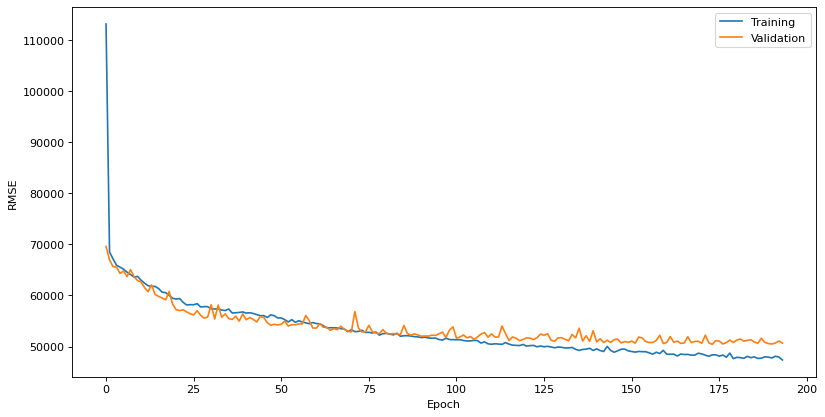

In [12]:
history = pipe.named_steps['keras'].history_
plot_rmse(history)

In [13]:
y_pred = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_pred)

255/255 [==============================] - 1s 3ms/step


50445.79560673367